# Qu. 3: Data Analysis and PageRank in Spark [46pt]

**Fill your ID Here:** 205614845

In this problem, you will learn how to implement the PageRank algorithm in Spark. <br>
The general computation should be done in Spark, and you may also include numpy operations whenever needed. <br>
Make sure the Page-Rank computation follows distributive map-reduce.

**Mathematical notations:** <br>
Assume that the **directed** graph  $G=(V,E)$  has  $n$  nodes (numbered $1, 2,...,n$)  $m$  edges. <br>
Let $E =[e_{ij}]_{n×n}$ is the adjencency matrix with $e_{ij}=1$ if there is a directed edge $i \to j$ and $e_{ij}=0$ otherwise. Denote by $d_i$ the out-degree of node $i$, and assume for simplicity that all nodes have positive out-degree (i.e. $d_i > 0 \: \forall i$, we have no dangling pages). <br>
Let $M =[m_{ij}]_{n×n}$  is an $n \times n$  stochastic matrix as defined in class, such that $m_{ij} = \frac{e_{ij}}{d_i}$ for any  $i,j∈\{1,..,n\}$. <br>
Let $\beta \in (0,1)$ be a probability of random surfer to go from a current web-page to a random neighbour via a random hyperlink, and let $1-\beta$ be the teleport probability, i.e the probability of going to a random page on the web.
The goal of the PageRank algorithm it to find the stationary distribution of the Markov Chain defined by the random surfer, or equivalently, the leading right eigenvector of the matrix $M' \equiv \beta M + \frac{1}{n}(1-\beta) {\bf 1}_n {\bf 1}_n^t$, where ${\bf 1}_n \equiv (1,1,..,1)^t \in \mathbb{R}^n$ is the vector of all ones of length $n$. <br>
When there are dangling pages, we set the corresponding row of $M$ to $\frac{1}{n}$ everywhere and the above formula remains valid.


**Implementation instructions:** <br>
You may choose to store the PageRank vector $r$ either in memory or as an RDD. <br>
But, the matrix $M$ of links is too large to store in memory, and you are allowed to store matrix $M$ only in an RDD. e.g.: <br>
`network_links = sc.textFile (”my-network.txt”)` if your network data is contained in the text file `"my-network.txt"`. <br>
On an actual cluster, an RDD is partitioned across the nodes of the cluster. However, you cannot then use the `M = data.collect()` command which fetches the entire RDD to a single machine at the driver node stores it as an array locally.


**Datasets:** <br>
We will compute PageRank for two network datasets, a *flight delays* network obtained from databricks, and the wikipedia network you extracted in question 1. We describe next the *flight delays* <br>

**Airline On-Time Performance and Causes of Flight Delays Database**. 
This database contains scheduled and actual departure and arrival times, and reason of delay.  
Reported by certified U.S. air carriers that account for at least one percent of domestic scheduled passenger revenues.   
The data is collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS).  
Source:  
https://catalog.data.gov/dataset/airline-on-time-performance-and-causes-of-flight-delays

Several datasets related to flights are available in databricks at `"databricks-datasets/flights/"`. <br>
You can read about them in the Readme file `"/databricks-datasets/flights/README.md"` and the available links in it. <br>
We will use two flight-related datasets to build our network:
1. A `flightDelays` dataset, available at `"/databricks-datasets/flights/departuredelays.csv"`
2. An `airports` dataset, available at `"/databricks-datasets/flights/airport-codes-na.txt"`

The `airports` dataset will be used to define the nodes of a **directed** network, where each node corresponds to an airport. <br>
The `flightDelays` dataset will be used to define the edges of the network, where each record corresponds to a (delayed) flight between two airports. 

Below we supply code for loading the datasets into two Spark data-frames: `airports` and `delays`

In [ ]:
# Required modules
import re
import sys
from operator import add

# Set File Paths
tripdelaysFilePath = "/databricks-datasets/flights/departuredelays.csv"
airportsnaFilePath = "/databricks-datasets/flights/airport-codes-na.txt"

# Obtain airports dataset
airports  = sqlContext.read.format("com.databricks.spark.csv").options(header='true', inferschema='true', delimiter='\t').load(airportsnaFilePath)
airports.registerTempTable("airports")

# Obtain departure Delays data
delays = sqlContext.read.format("com.databricks.spark.csv").options(header='true').load(tripdelaysFilePath)
delays.registerTempTable("delays")
delays.cache()

**3.a. [3pt]** Show the top 10 airport and top 10 delays from both dataframes in a nice table format

The top 10 airports

In [ ]:
%sql
SELECT *
FROM airports
LIMIT 10

In [ ]:
# Alternative command (in order to be able showing results in the ipynb notebook)
airports.show(10)

In [ ]:
+-----------+-----+-------+----+
|       City|State|Country|IATA|
+-----------+-----+-------+----+
| Abbotsford|   BC| Canada| YXX|
|   Aberdeen|   SD|    USA| ABR|
|    Abilene|   TX|    USA| ABI|
|      Akron|   OH|    USA| CAK|
|    Alamosa|   CO|    USA| ALS|
|     Albany|   GA|    USA| ABY|
|     Albany|   NY|    USA| ALB|
|Albuquerque|   NM|    USA| ABQ|
| Alexandria|   LA|    USA| AEX|
|  Allentown|   PA|    USA| ABE|
+-----------+-----+-------+----+
only showing top 10 rows

The top 10 delays


In [ ]:
# Show the top 10 delays

%sql 
SELECT *
FROM delays
LIMIT 10

In [ ]:
# Alternative command (in order to be able showing results in the ipynb notebook)
delays.show(10)

In [ ]:
+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245|    6|     602|   ABE|        ATL|
|01020600|   -8|     369|   ABE|        DTW|
|01021245|   -2|     602|   ABE|        ATL|
|01020605|   -4|     602|   ABE|        ATL|
|01031245|   -4|     602|   ABE|        ATL|
|01030605|    0|     602|   ABE|        ATL|
|01041243|   10|     602|   ABE|        ATL|
|01040605|   28|     602|   ABE|        ATL|
|01051245|   88|     602|   ABE|        ATL|
|01050605|    9|     602|   ABE|        ATL|
+--------+-----+--------+------+-----------+
only showing top 10 rows

**3.b. [9pt]** Run sql commands to answer the following questions: <br>
**(i)** What US city incurs the most delays as an `origin` airport? Run an sql query to find out. <br>
**(ii)** We would like to know, for each origin airport and state combination, <br>
the average distance and delay of all outgoing flights with positive delays. <br>
In addition, in the same query, we would like to see the average state delay <br>
(regardless of origin airport) for each airport-state combination with positive delay.

Write an sql query that returns  `origin`, `state`, and also: <br>
`average distance` (mean distance between origin and destinations over all outgoing flights) <br>
`average delay` (average delay of all outgoing flights from an origin, with a positive delay) <br>
`average state delay` (average dealy over all outgloing flights from all airports in the same state, with a positive delay). 

The query should return the results sorted by decreasing `average state delay`, with only the first 10 rows shown.   <br>

`Hint:` use a `window function` among other sql commands. <br>
**(iii)** We would like to compute the PageRank vector only for `origin` nodes that have outgoing edges. <br>
Remove from the `delays` dataframe all the records of flights connecting to destination aiports that <br>
appear only as `destination` (also called dead-end nodes, or dangling page). <br>
That is, if a record contains as `origin` an airport called `ABC`, and as `destination` an airport called `XYZ`, <br>
you should keep it only if `XYZ` is an `origin` airport for another record. <br>
Use an sql command **inside python using Spark.sql**, and update the `delays` variable to contain the output.

(i) The US city incurs the most delays as an origin airport

In [ ]:
%sql
SELECT city
FROM delays

LEFT JOIN airports 
ON delays.origin = airports.IATA
WHERE airports.country IN ('USA')

GROUP BY city
ORDER BY COUNT(city) DESC
LIMIT 1

Atlanta

(ii) The average distance and delay of all outgoing flights with positive delays for each origin airport and state combination.
In addition, the average state delay (regardless of origin airport) for each airport-state combination with positive delay.
The results sorted by decreasing average state delay, with only the first 10 rows shown.

In [ ]:
%sql
SELECT DISTINCT origin, State, AVG(delay) OVER(PARTITION BY origin) AS Average_Delays_Per_Origin, 
AVG(distance) OVER(PARTITION BY origin) AS Average_Distance_Per_Origin, 
AVG(delay) OVER(PARTITION BY State) AS Average_Delays_Per_State
FROM delays

LEFT JOIN airports 
ON delays.origin = airports.IATA

WHERE delay > 0
ORDER BY Average_Delays_Per_State DESC
LIMIT 10

Note - the outputes of an Sql queries aren't shown after the converting from the Html of databricks to a pdf file, therefore I attach a picture of the output.
The output:

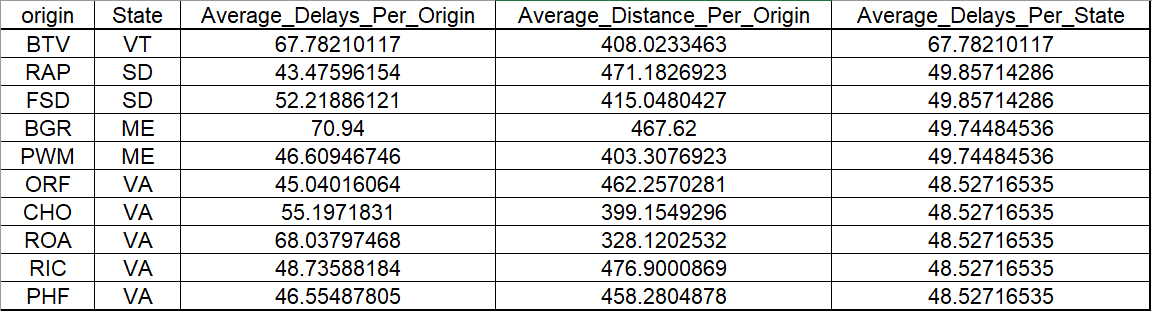

(iii) Remove from the delays dataframe all the records of flights connecting to destination aiports that appear only as destination.

In [ ]:
# Helpful source: https://stackoverflow.com/questions/43515193/how-to-delete-rows-in-a-table-created-from-a-spark-dataframe

delays = spark.sql("SELECT * FROM delays WHERE destination IN (SELECT origin FROM delays GROUP BY origin)")

**3.c[6 pt]**
In this question we build an object representing the network of delayed flights connecting between airports, as a preparation for the PageRank algorithm. <br>
For this, we will only look at the `origin` and `destination` columns, not giving any weight to the `delay` time.  <br>
Each (`origin`, `destination`) pair should have at most one link in the the network, even if there are multipled delayed flights connecting them. <br>

Create a new `RDD` data structure of tuples called `ranks`, storing the initial PageRank value for each `origin` node. 
Set the initialization value as `1/n` for all nodes, where `n` is the number of `origin` node. <br>
We will ignore nodes that are only `destination` and do no not appear as `origin`, in order to avoid dangling pages and to simplify the calculations. <br>

Next, create another `RDD` data structure of tuples, named `links`, where each tuple is composed of the `origin` and an iterator (a `GroupByKey`) of the `destination`. <br>
Show the first $10$ rows of the resulting `links` and `ranks` `RDD` data structures.

Create an RDD data structure of tuples called ranks:

In [ ]:
# I used many sources of data:

# https://stackoverflow.com/questions/30248221/removing-duplicates-from-rows-based-on-specific-columns-in-an-rdd-spark-datafram
# https://www.educba.com/spark-commands/
# https://sparkbyexamples.com/spark/spark-select-columns-from-dataframe/
# https://sparkbyexamples.com/spark/spark-add-new-column-to-dataframe/
# https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark
# https://regenerativetoday.com/20-very-commonly-used-functions-of-pyspark-rdd/

# drop duplicates from the delays self created data structure
new_delays = delays.dropDuplicates(['origin'])

# count numbers of nodes
n = new_delays.count()
InitialPageRank = 1/n

# create an RDD data sturcture which contains only the different origins
new_delays = new_delays.select('origin')
# convert to an RDD
ranks = new_delays.rdd

# design the RDD with tuples which contain (origin, initial page rank)
ranks = ranks.flatMap(lambda x: x)
ranks = ranks.map(lambda x: (x, InitialPageRank))

ranks.take(10)

[('GEG', 0.00392156862745098),
 ('BUR', 0.00392156862745098),
 ('GTF', 0.00392156862745098),
 ('GRB', 0.00392156862745098),
 ('GRR', 0.00392156862745098),
 ('EUG', 0.00392156862745098),
 ('GSO', 0.00392156862745098),
 ('COD', 0.00392156862745098),
 ('FAR', 0.00392156862745098),
 ('FSM', 0.00392156862745098)]

Create an RDD data structure of tuples called links:

In [ ]:
# For the following question I used this source of data:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.groupByKey.html

# Drop duplicates of origin-destination
new_delays = delays.dropDuplicates(['origin', 'destination'])

# create an RDD data sturcture which contains only the different origin-destination links 
new_delays = new_delays.select('origin', 'destination')
links = new_delays.rdd

# Merge all the destinations of the same origin into a list
links = links.groupByKey().mapValues(list)

links.take(10)

[('ATL',
  ['MSY',
   'SNA',
   'GRB',
   'GRR',
   'PVD',
   'GSO',
   'MYR',
   'MSN',
   'FSM',
   'FAR',
   'DCA',
   'MLU',
   'GTR',
   'CID',
   'LEX',
   'ORF',
   'EVV',
   'CRW',
   'SAV',
   'TRI',
   'CMH',
   'CAK',
   'CHO',
   'MOB',
   'PNS',
   'IAH',
   'HNL',
   'SHV',
   'CVG',
   'SJC',
   'BUF',
   'TLH',
   'LGA',
   'HPN',
   'AUS',
   'MLI',
   'SJU',
   'DHN',
   'ATW',
   'AVL',
   'SRQ',
   'EYW',
   'SBN',
   'JAC',
   'CHS',
   'RSW',
   'TUL',
   'BOS',
   'MLB',
   'EWR',
   'LAS',
   'JAN',
   'XNA',
   'DEN',
   'ALB',
   'IAD',
   'BMI',
   'SEA',
   'VLD',
   'MCI',
   'BNA',
   'CLT',
   'PBI',
   'ABQ',
   'SDF',
   'BDL',
   'DAL',
   'CLE',
   'PDX',
   'MIA',
   'TPA',
   'BWI',
   'ROA',
   'OKC',
   'SMF',
   'PHX',
   'STL',
   'PWM',
   'ABY',
   'DFW',
   'MHT',
   'ABE',
   'GSP',
   'FAY',
   'HDN',
   'EGE',
   'FSD',
   'CSG',
   'BQK',
   'SFO',
   'MEM',
   'ELP',
   'BHM',
   'FLL',
   'FNT',
   'RIC',
   'DAY',
   'PHF',
   'OMA',
   'VPS',
   'LIT',
   'ICT',
   'CAE',
   'ORD',
   'AVP',
   'BTV',
   'AEX',
   'ILM',
   'PIA',
   'RDU',
   'MKE',
   'SYR',
   'HSV',
   'LFT',
   'PIT',
   'MTJ',
   'TUS',
   'MDW',
   'COS',
   'OAJ',
   'IND',
   'GPT',
   'MGM',
   'DTW',
   'HOU',
   'TYS',
   'CHA',
   'ONT',
   'MDT',
   'FWA',
   'JAX',
   'LAX',
   'MSP',
   'BTR',
   'MCO',
   'ROC',
   'AGS',
   'SGF',
   'SAN',
   'BZN',
   'JFK',
   'DAB',
   'GNV',
   'PHL',
   'DSM',
   'SLC',
   'SAT',
   'STT',
   'PSP']),
 ('AUS',
  ['MSY',
   'OAK',
   'DCA',
   'IAH',
   'SJC',
   'LGB',
   'HRL',
   'BOS',
   'EWR',
   'LAS',
   'DEN',
   'IAD',
   'SEA',
   'CLT',
   'BNA',
   'DAL',
   'CLE',
   'TPA',
   'BWI',
   'PHX',
   'DFW',
   'LBB',
   'SFO',
   'ELP',
   'FLL',
   'ATL',
   'ORD',
   'MDW',
   'DTW',
   'HOU',
   'LAX',
   'MCO',
   'SAN',
   'JFK',
   'PHL',
   'SLC',
   'MSP']),
 ('BNA',
  ['MSY',
   'DCA',
   'ORF',
   'CMH',
   'PNS',
   'IAH',
   'CVG',
   'LGA',
   'AUS',
   'CHS',
   'RSW',
   'BOS',
   'EWR',
   'LAS',
   'DEN',
   'IAD',
   'MCI',
   'CLT',
   'CLE',
   'MIA',
   'BWI',
   'TPA',
   'PHX',
   'STL',
   'DFW',
   'GSP',
   'MEM',
   'ATL',
   'FLL',
   'ORD',
   'RDU',
   'PIT',
   'MDW',
   'DTW',
   'HOU',
   'JAX',
   'LAX',
   'MSP',
   'MCO',
   'SAN',
   'JFK',
   'PHL',
   'SLC',
   'SAT']),
 ('BOS',
  ['MSY',
   'DCA',
   'CAK',
   'IAH',
   'SJC',
   'CVG',
   'BUF',
   'LGA',
   'AUS',
   'SJU',
   'LGB',
   'SRQ',
   'CHS',
   'RSW',
   'EWR',
   'LAS',
   'DEN',
   'IAD',
   'SEA',
   'MCI',
   'CLT',
   'BNA',
   'PBI',
   'CLE',
   'PDX',
   'MIA',
   'TPA',
   'BWI',
   'PHX',
   'STL',
   'DFW',
   'SFO',
   'FLL',
   'ATL',
   'RIC',
   'ORD',
   'RDU',
   'MKE',
   'PIT',
   'MDW',
   'HOU',
   'DTW',
   'JAX',
   'LAX',
   'MSP',
   'MCO',
   'SAN',
   'JFK',
   'PHL',
   'SLC',
   'STT',
   'SAV']),
 ('BWI',
  ['MSY',
   'GRR',
   'PVD',
   'ORF',
   'CMH',
   'IAH',
   'BUF',
   'AUS',
   'SJU',
   'CHS',
   'RSW',
   'ISP',
   'BOS',
   'EWR',
   'LAS',
   'DEN',
   'ALB',
   'MCI',
   'CLT',
   'BNA',
   'PBI',
   'ABQ',
   'SDF',
   'BDL',
   'CLE',
   'MIA',
   'TPA',
   'OKC',
   'PHX',
   'STL',
   'PWM',
   'DFW',
   'MHT',
   'GSP',
   'SFO',
   'MEM',
   'BHM',
   'ATL',
   'FLL',
   'FNT',
   'DAY',
   'LIT',
   'ORD',
   'RDU',
   'MKE',
   'PIT',
   'MDW',
   'IND',
   'DTW',
   'HOU',
   'JAX',
   'MSP',
   'LAX',
   'MCO',
   'ROC',
   'SAN',
   'JFK',
   'PHL',
   'SLC',
   'SAT']),
 ('CLE',
  ['MSY',
   'GRR',
   'PVD',
   'MSN',
   'DCA',
   'CMH',
   'IAH',
   'LGA',
   'BUF',
   'AUS',
   'SJU',
   'CHS',
   'RSW',
   'BOS',
   'EWR',
   'LAS',
   'DEN',
   'ALB',
   'IAD',
   'SEA',
   'MCI',
   'CLT',
   'BNA',
   'PBI',
   'SDF',
   'BDL',
   'MIA',
   'BWI',
   'TPA',
   'OKC',
   'PHX',
   'STL',
   'DFW',
   'MHT',
   'GSP',
   'SFO',
   'ATL',
   'FLL',
   'RIC',
   'DAY',
   'ORD',
   'BTV',
   'RDU',
   'MKE',
   'SYR',
   'PIT',
   'MDW',
   'IND',
   'DTW',
   'MSP',
   'LAX',
   'ROC',
   'MCO',
   'SAN',
   'JFK',
   'PHL']),
 ('CLT',
  ['MSY',
   'PVD',
   'GSO',
   'DCA',
   'ORF',
   'CMH',
   'IAH',
   'LGA',
   'BUF',
   'AUS',
   'SJU',
   'SRQ',
   'CHS',
   'RSW',
   'BOS',
   'EWR',
   'LAS',
   'DEN',
   'ALB',
   'IAD',
   'SEA',
   'MCI',
   'BNA',
   'PBI',
   'BDL',
   'CLE',
   'PDX',
   'MIA',
   'BWI',
   'TPA',
   'PHX',
   'STL',
   'PWM',
   'DFW',
   'STX',
   'SFO',
   'MEM',
   'ATL',
   'FLL',
   'RIC',
   'ORD',
   'ILM',
   'RDU',
   'SYR',
   'PIT',
   'MDW',
   'IND',
   'DTW',
   'HOU',
   'MDT',
   'JAX',
   'MSP',
   'LAX',
   'MCO',
   'ROC',
   'SAN',
   'JFK',
   'PHL',
   'SLC',
   'SAT',
   'STT',
   'CVG',
   'MHT',
   'DAB',
   'SMF',
   'OMA']),
 ('DAL',
  ['MSY',
   'IAH',
   'AUS',
   'TUL',
   'HRL',
   'AMA',
   'MAF',
   'MCI',
   'ABQ',
   'OKC',
   'STL',
   'LBB',
   'ELP',
   'BHM',
   'ATL',
   'LIT',
   'ICT',
   'HOU',
   'SAT']),
 ('DEN',
  ['MSY',
   'GEG',
   'SNA',
   'BUR',
   'GTF',
   'IDA',
   'GRR',
   'EUG',
   'GSO',
   'OAK',
   'MSN',
   'FAR',
   'COD',
   'DCA',
   'CID',
   'HLN',
   'RDM',
   'CMH',
   'CAK',
   'LIH',
   'IAH',
   'HNL',
   'SHV',
   'CVG',
   'SJC',
   'LGA',
   'MLI',
   'AUS',
   'GJT',
   'BFL',
   'RNO',
   'JAC',
   'TUL',
   'RSW',
   'AMA',
   'BOS',
   'MAF',
   'EWR',
   'BIS',
   'LAS',
   'XNA',
   'SGU',
   'CPR',
   'LNK',
   'SBA',
   'PSP',
   'BOI',
   'IAD',
   'DRO',
   'BMI',
   'SEA',
   'MCI',
   'BNA',
   'CLT',
   'PSC',
   'ABQ',
   'SDF',
   'MRY',
   'BDL',
   'CLE',
   'PDX',
   'MIA',
   'MFR',
   'TPA',
   'BWI',
   'OKC',
   'SMF',
   'PHX',
   'FCA',
   'STL',
   'DFW',
   'HDN',
   'GUC',
   'LBB',
   'EGE',
   'FSD',
   'SFO',
   'MEM',
   'ELP',
   'BHM',
   'ATL',
   'FLL',
   'DAY',
   'PHF',
   'OMA',
   'LIT',
   'ICT',
   'FAT',
   'ORD',
   'BIL',
   'PIA',
   'RDU',
   'MKE',
   'HSV',
   'TUS',
   'MTJ',
   'PIT',
   'MDW',
   'COS',
   'IND',
   'KOA',
   'DTW',
   'TYS',
   'HOU',
   'MDT',
   'ONT',
   'JAX',
   'MSP',
   'MOT',
   'LAX',
   'SGF',
   'MCO',
   'SAN',
   'BZN',
   'JFK',
   'ANC',
   'MSO',
   'PHL',
   'OGG',
   'DSM',
   'SLC',
   'SAT',
   'RAP']),
 ('DFW',
  ['MSY',
   'SNA',
   'GRR',
   'GSO',
   'FAR',
   'FSM',
   'MSN',
   'DCA',
   'MLU',
   'CID',
   'LEX',
   'ORF',
   'EVV',
   'CRW',
   'SAV',
   'CMH',
   'TYR',
   'MOB',
   'PNS',
   'IAH',
   'HNL',
   'SHV',
   'SJC',
   'CVG',
   'LGA',
   'TLH',
   'ACT',
   'AUS',
   'MLI',
   'SJU',
   'GJT',
   'RNO',
   'JAC',
   'CHS',
   'RSW',
   'TUL',
   'AMA',
   'BOS',
   'MAF',
   'EWR',
   'LAS',
   'JAN',
   'XNA',
   'DEN',
   'PSP',
   'IAD',
   'DRO',
   'BRO',
   'BMI',
   'SEA',
   'CMI',
   'LRD',
   'MCI',
   'CLT',
   'BNA',
   'CLL',
   'ABQ',
   'PBI',
   'SDF',
   'LAW',
   'BDL',
   'CLE',
   'PDX',
   'MIA',
   'BWI',
   'TPA',
   'OKC',
   'SMF',
   'ABI',
   'PHX',
   'STL',
   'TXK',
   'GSP',
   'HDN',
   'GUC',
   'LBB',
   'CRP',
   'EGE',
   'FSD',
   'SFO',
   'MEM',
   'ELP',
   'BHM',
   'ATL',
   'FLL',
   'RIC',
   'DAY',
   'OMA',
   'SJT',
   'LCH',
   'VPS',
   'BPT',
   'LIT',
   'ICT',
   'FAT',
   'CAE',
   'ORD',
   'AEX',
   'SPS',
   'PIA',
   'RDU',
   'MFE',
   'MKE',
   'HSV',
   'LFT',
   'PIT',
   'TUS',
   'MTJ',
   'COS',
   'IND',
   'GPT',
   'MGM',
   'DTW',
   'HOU',
   'TYS',
   'CHA',
   'ONT',
   'FWA',
   'JAX',
   'MSP',
   'LAX',
   'BTR',
   'MCO',
   'SGF',
   'SAN',
   'GGG',
   'JFK',
   'OGG',
   'PHL',
   'DSM',
   'SLC',
   'SAT',
   'RAP'])]

**3.d. [6pt]** 
Recall the PageRank algorithm: 
1. Set $r = \frac{1}{n} {\bf 1}_n$
2. For $i=1$ to $I$: <br>
&nbsp;&nbsp;     Set $r \leftarrow \frac{1-\beta}{n} {\bf 1}_n + \beta M^t r$

The conts function below, is used to create an iterator that transfers from the ranks vector $r$ to $M r$ , that is used in each iteration of the algorithm
(in part 2 above). <br>
Using the conts function, join the ranks to the links data, and create an `RDD` object called `contrib`, which stores for each node $j$ the 
sum $\sum_{i=1}^n m_{ij} r_i$, i.e. the contributions of the PageRank scores over all of the nodes that link to it. <br>
Display the top $10$ values of the resulting `RDD`

**Hint:** First, use `flatmap` to obtain the contribution $m_{ij} r_i$ for each link $i \to j$. Then, reduce to sum the contributions from all links going into the same `destination` node $j$.

Next, update the `ranks` vector using the resulting `contrib` according to the Page Rank algorithm, with $\beta=0.85$. This completes one iteration of the algorithm. <br>
Display the first $10$ values of the resulting `ranks` `RDD`

In [ ]:
# helpful function:

# Converts nodes iterator and ranks vec to ranks normalized by out-degree  
def conts(nodes, rank): 
    """For each node in the graph calculate the number of connected  nodes, 
    and for each provide an node, adjusted rank by size of connected nodes:
    """
    num_nodes = len(nodes)
    for node in nodes:
        yield (node, rank / num_nodes)

In [ ]:
# The following Website was really helphul for D question: 
# https://cocalc.com/share/public_paths/960fae18301f8e8cb29472dc3ff5d0acf5659ec8/data-analysis%2Fspark-pagerank.ipynb

# Other helpful sourses:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html
# https://stackoverflow.com/questions/31882221/spark-select-top-values-in-rdd
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sortBy.html
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.join.html

# Join the 2 RDD data frames
c = links.join(ranks)

# Using the helpful function: for every origin node I will input a list of 
# destination nodes x[1][0] and current page rank x[1][1], and get the output 
# of its page rank score.
c = c.flatMap(lambda x: conts(x[1][0], x[1][1]))

# Using reduce by key in order to sum all the page rank scores of the same origin, 
# and update its final page rank score.
contrib = c.reduceByKey(add)

# Show the top 10 highest page ranks after sorting the RDD contrib data frame 
# by page rank descending order
contrib.sortBy(lambda x: x[1], ascending = False).take(10)

[('ATL', 0.10849068424486911),
 ('DFW', 0.09414305105194286),
 ('ORD', 0.08918146875067194),
 ('DEN', 0.05752553866945789),
 ('SLC', 0.05038730893665222),
 ('IAH', 0.04469947546353584),
 ('MSP', 0.038048557642486575),
 ('DTW', 0.033696298463348213),
 ('SFO', 0.03359482794572101),
 ('LAX', 0.02841409696993441)]

In [ ]:
# https://cocalc.com/share/public_paths/960fae18301f8e8cb29472dc3ff5d0acf5659ec8/data-analysis%2Fspark-pagerank.ipynb

# Define beta value
beta = 0.85

update_ranks = contrib
# Update the value of page rank scores
ranks = update_ranks.mapValues(lambda x: x*beta + ((1-beta)/n))

ranks.take(10)

[('SNA', 0.0015882720445938433),
 ('GRB', 0.0007070855040634512),
 ('PVD', 0.0015627541914892814),
 ('MYR', 0.0007041408709491709),
 ('FSM', 0.000635669315412495),
 ('FAR', 0.001876057548516882),
 ('DCA', 0.004443820182565609),
 ('GTR', 0.000610606658770891),
 ('CID', 0.0007592484317077654),
 ('EVV', 0.000811629696532886)]

**3.e. [6pt]:** The above code implemented one iteration of the PageRank algorithm. <br>
Use a loop to apply $50$ iterations starting from the uniform initialization, and with a `beta` of $0.85$. <br>
Show the $10$ airports with the highest PageRank score, along with their PageRank values, and City name.

Implementation of PageRank here

loop to apply  50  iterations starting from the uniform initialization, and with a beta of  0.85

In [ ]:
# initialization the ranks RDD data frame

# drop duplicates from the delays self created data structure
new_delays = delays.dropDuplicates(['origin'])

# count numbers of nodes
n = new_delays.count()
InitialPageRank = 1/n

# create an RDD data sturcture which contains only the different origins 
new_delays = new_delays.select('origin')
# convert to an RDD
ranks = new_delays.rdd

# design the RDD with tuples which contain (origin, initial page rank)
ranks = ranks.flatMap(lambda x: x)
ranks = ranks.map(lambda x: (x, InitialPageRank))

# Defined beta value
beta = 0.85

# The 50 iterations:
for i in range(50):
    # Join the 2 RDD data frames
    contrib = links.join(ranks)

    # Using the helpful function: for every origin node I will input a list of 
    # destination nodes x[1][0] and current page rank x[1][1], and get the output 
    # of its page rank score.
    contrib = contrib.flatMap(lambda x: conts(x[1][0], x[1][1]))

    # Using reduce by key in order to sum all the page rank scores of the same origin, 
    # and update its final page rank score.
    contrib = contrib.reduceByKey(add)
    
    # Update the rank RDD data frame with the new page rank scores of every 
    # node of origin:
    update_ranks = contrib
    ranks = update_ranks.mapValues(lambda x: x*beta + ((1-beta)/n))
    # print(i)

# Sort the ranks RDD data frame by dcending order (of the page rank)
ranks = ranks.sortBy(lambda x: x[1], ascending = False)

Show the  10  airports with the highest PageRank score, 
along with their PageRank values, and City name 
(By merging 2 data frame: 1 -> airport, page rank score with 2 -> city name)

In [ ]:
# Convert the ranks RDD data frame to a panda data frame
# Useful source: https://sparkbyexamples.com/pyspark/convert-pyspark-rdd-to-dataframe/
PageRankColumns = ["IATA","Page_Rank"]
PageRankScore = ranks.toDF(PageRankColumns)

# Join between the ranks data frame version to the airports data frame.
#https://www.learnbymarketing.com/1100/pyspark-joins-by-example/
right_join = airports.join(PageRankScore, airports.IATA == PageRankScore.IATA, how='right')

# https://stackoverflow.com/questions/59883306/how-to-drop-a-column-from-a-spark-dataframe-by-index-where-column-names-can-be-d
colnames = right_join.columns
right_join = right_join.toDF(*map(str, range(len(colnames))))

# Delete one duplicte column from the merge data frame
right_join = right_join.select(['0', '4', '5'])
data_list = ['City', 'IATA', 'Page_Rank']
right_join = right_join.toDF(*data_list)

# Show the  10  airports with the highest PageRank score, along with their
# PageRank values, and City name.
right_join.show(10)

In [ ]:
+--------------+----+--------------------+
|          City|IATA|           Page_Rank|
+--------------+----+--------------------+
|       Atlanta| ATL| 0.04018615754388132|
|       Chicago| ORD| 0.03602199122572931|
|        Dallas| DFW|  0.0357942645015176|
|        Denver| DEN|  0.0292347360567124|
|       Houston| IAH|0.024251444219820645|
|   Minneapolis| MSP|0.021245471805183106|
|Salt Lake City| SLC|0.020939022629145803|
|       Detroit| DTW|0.019992110144999315|
|   Los Angeles| LAX|0.017927534884944456|
| San Francisco| SFO| 0.01744728195811835|
+--------------+----+--------------------+
only showing top 10 rows

In [ ]:
right_join.take(10)

[Row(City='Atlanta', IATA='ATL', Page_Rank=0.04018615754388132),
 Row(City='Chicago', IATA='ORD', Page_Rank=0.03602199122572931),
 Row(City='Dallas', IATA='DFW', Page_Rank=0.0357942645015176),
 Row(City='Denver', IATA='DEN', Page_Rank=0.0292347360567124),
 Row(City='Houston', IATA='IAH', Page_Rank=0.024251444219820645),
 Row(City='Minneapolis', IATA='MSP', Page_Rank=0.021245471805183106),
 Row(City='Salt Lake City', IATA='SLC', Page_Rank=0.020939022629145803),
 Row(City='Detroit', IATA='DTW', Page_Rank=0.019992110144999315),
 Row(City='Los Angeles', IATA='LAX', Page_Rank=0.017927534884944456),
 Row(City='San Francisco', IATA='SFO', Page_Rank=0.01744728195811835)]

**3.f [4pt]** In this sub-question we run the PageRank algoithm on the much larger, `wikiepdia` dataset. <br>
Load the `wikipedia` network dataset file created in Quesion 1. <br> 
Your uploaded datasets can be accessed via:  `dbfs:/FileStore/shared_uploads/your.account.email@whatever.ending.you.have.com/` <br>
You should upload into two `RDD` objects using the `sc.textFile` command: <br>
One, called `keyvalue` containing the nodes, uploaded from the `keyvalue` file. <br> 
Another, called `transition` containing the edges, uploaded from the file created in Question 1.b., in the format of one edge (two IDs) per line. <br>
Display the top $10$ (nodes or edges) for each `RDD`

In [ ]:
# Code for loading the nodes and edges into separate `RDD`s

keyvaluepath = "dbfs:/FileStore/shared_uploads/Orel.BenIsrael@mail.huji.ac.il/keyvalue"
transitionpath = "dbfs:/FileStore/shared_uploads/Orel.BenIsrael@mail.huji.ac.il/network"

keyvalueRDD = sc.textFile(keyvaluepath)
transitionRDD = sc.textFile(transitionpath)

In [ ]:
# Design the RDD with tuples of 2 arguments: ID web, URL Website

# Convert the '\t' sign to a comma
keyvalueRDD = keyvalueRDD.map(lambda x: x.split('\t'))
# Conert the inner lists to tuples
keyvalueRDD = keyvalueRDD.map(lambda x:(x[0], x[1]))

keyvalueRDD.take(10)

[('0', 'https://en.wikipedia.org/wiki/Category:Statistics'),
 ('1', 'https://en.wikipedia.org/wiki/Help:Category'),
 ('2', 'https://en.wikipedia.org/wiki/Portal:Mathematics'),
 ('3', 'https://en.wikipedia.org/wiki/Help:Categories'),
 ('4', 'https://en.wikipedia.org/wiki/Statistics'),
 ('5', 'https://en.wikipedia.org/wiki/Correlates_of_crime'),
 ('6', 'https://en.wikipedia.org/wiki/Hawkes_process'),
 ('7', 'https://en.wikipedia.org/wiki/Scagnostics'),
 ('8', 'https://en.wikipedia.org/wiki/Special:MyTalk'),
 ('9', 'https://en.wikipedia.org/wiki/Main_Page')]

In [ ]:
# Design the RDD with tuples of 2 arguments: source Website ID, destination Website ID

# Convert the space (" ") to a comma
transitionRDD = transitionRDD.map(lambda x: x.split(' '))
# Conert the inner lists to tuples
transitionRDD = transitionRDD.map(lambda x:(x[0], x[1]))

transitionRDD.take(10)

[('0', '1'),
 ('0', '2'),
 ('0', '3'),
 ('0', '4'),
 ('0', '5'),
 ('0', '6'),
 ('0', '7'),
 ('0', '8'),
 ('0', '0'),
 ('0', '9')]

**3.g.[6pt]** We want to avoid dangling pages when running the PageRank algorithm. <br>
To do so, convert the transition `RDD` into a data-frame. 
In this data-frame, remove all links where the destination webpage does not appear as one of the source webpages (in similar to 1.c.). <br>
Repeat the process until you get a sub-network where every node is a source-node, 
i.e, has a positive out-degree (you may need to repeat the process more than once). 

**Remark** In order to access a Spark data-frame via Spark.sql, you need to first declare it. For example, if your data-frame is called `transition_df`, 
add to your code the line: `transition_df.createOrReplaceTempView("transition_df")`

In [ ]:
# Spark + Spark.sql code for removing edges and nodes to retain only nodes with out-degree. 
# https://sparkbyexamples.com/pyspark/pyspark-convert-dataframe-to-rdd/

# Convert the RDD to a data frame, A is the column of source webs, B is the column of destination webs
transitioncolumns = ["A", "B"]
transitionDF = transitionRDD.toDF(transitioncolumns)

In [ ]:
# Loop for removing all links where the destination webpage does not appear as one of the source webpages 

firstCount = 1
secondCount = 0

while (firstCount - secondCount != 0):
    transitionDF.createOrReplaceTempView("transitionDF")
    transitionDF = spark.sql("SELECT * FROM transitionDF WHERE B IN (SELECT A FROM transitionDF GROUP BY A)")
    firstCount = transitionDF.count()

    transitionDF.createOrReplaceTempView("transitionDF")
    transitionDF = spark.sql("SELECT * FROM transitionDF WHERE B IN (SELECT A FROM transitionDF GROUP BY A)")
    secondCount = transitionDF.count()

**3.h.[6pt]** Finally, run the PageRank algorithm on the wikipedia netowrk, with 10 iterations and $\beta=0.85$, and a uniform ranks vector initialization. <br>
Your implementation should be similar to the implementation for the flight delays dataset. 
Show the 20 `wikipedia` pages with the highest PageRank values you got (the `url` along with their PageRank scores)

Code for PageRank implementation for wikipedia

Create a web page ranks RDD

In [ ]:
# Initialization the page rank score for every source web page

# drop duplicates from the transitionDF by column A
new_transitionDF = transitionDF.dropDuplicates(['A'])

# count numbers of nodes
n = new_transitionDF.count()
InitialPageRank = 1/n

# create an RDD data sturcture which contains only the different source web page
new_transitionDF = new_transitionDF.select('A')
# convert to an RDD
ranks_transition = new_transitionDF.rdd

# design the RDD with tuples which contain (source web page, initial page rank)
ranks_transition = ranks_transition.flatMap(lambda x: x)
ranks_transition = ranks_transition.map(lambda x: (x, InitialPageRank))

ranks_transition.take(10)

[('23459', 2.128701279349469e-05),
 ('21452', 2.128701279349469e-05),
 ('15574', 2.128701279349469e-05),
 ('47092', 2.128701279349469e-05),
 ('36526', 2.128701279349469e-05),
 ('42686', 2.128701279349469e-05),
 ('36470', 2.128701279349469e-05),
 ('106506', 2.128701279349469e-05),
 ('32275', 2.128701279349469e-05),
 ('15555', 2.128701279349469e-05)]

Create a web page links RDD

In [ ]:
# Drop duplicates of sorce-destination webpage links
new_transitionDF = transitionDF.dropDuplicates(['A', 'B'])

# create an RDD data sturcture which contains only the different source-destination webpage links 
new_transitionDF = new_transitionDF.select('A', 'B')
links_transition = new_transitionDF.rdd

# Merge all the destinations of the same source webpage into a list
links_transition = links_transition.groupByKey().mapValues(list)

links_transition.take(10)

[('60820',
  ['1034751',
   '60392',
   '1034734',
   '71192',
   '715580',
   '1034737',
   '1034748',
   '1034738',
   '336448',
   '1034750',
   '1034754',
   '1034753',
   '49288',
   '1034745',
   '1034741',
   '1034740',
   '1034759',
   '1034743',
   '1034746',
   '170538',
   '48958',
   '1034732',
   '62864',
   '1034736',
   '1034752',
   '908764',
   '1034739',
   '365993',
   '1034733',
   '60820',
   '1034747',
   '1034758',
   '1034735',
   '804172',
   '63954',
   '1034757',
   '1034756',
   '62188',
   '1034755',
   '204574',
   '170379',
   '1034744',
   '1034742',
   '25781',
   '1034749']),
 ('804172',
  ['1034751',
   '60392',
   '1034734',
   '715580',
   '61980',
   '1034737',
   '1034748',
   '1034738',
   '336448',
   '1034750',
   '1034754',
   '1034753',
   '1034745',
   '19273',
   '1034741',
   '1034740',
   '1034759',
   '1034743',
   '1034746',
   '170538',
   '48958',
   '1034732',
   '62864',
   '1034736',
   '1034752',
   '908764',
   '1034739',
   '1034733',
   '60820',
   '1034747',
   '1034758',
   '1034735',
   '804172',
   '63954',
   '1034757',
   '1034756',
   '62188',
   '1034755',
   '204574',
   '170379',
   '1034744',
   '65482',
   '1034742',
   '1034749']),
 ('1034748',
  ['1034751',
   '60392',
   '1034734',
   '715580',
   '1034737',
   '1034748',
   '1034738',
   '336448',
   '1034750',
   '1034754',
   '1034753',
   '49288',
   '1034745',
   '1034741',
   '1034740',
   '1034759',
   '1034743',
   '1034746',
   '170538',
   '48958',
   '1034732',
   '62864',
   '1034736',
   '1034752',
   '908764',
   '1034739',
   '1034733',
   '60820',
   '1034747',
   '1034758',
   '1034735',
   '804172',
   '63954',
   '1034757',
   '1034756',
   '62188',
   '1034755',
   '204574',
   '170379',
   '1034744',
   '1034742',
   '1034749']),
 ('336448',
  ['1034751',
   '60392',
   '1034734',
   '715580',
   '1034737',
   '1034748',
   '1034738',
   '336448',
   '1034750',
   '1034754',
   '1034753',
   '1034745',
   '1034741',
   '1034740',
   '1034759',
   '1034743',
   '1034746',
   '170538',
   '48958',
   '1034732',
   '62864',
   '1034736',
   '1034752',
   '908764',
   '1034739',
   '1034733',
   '60820',
   '1034747',
   '1034758',
   '1034735',
   '804172',
   '63954',
   '1034757',
   '49496',
   '1034756',
   '62188',
   '1034755',
   '204574',
   '170379',
   '1034744',
   '62610',
   '1034742',
   '1034749']),
 ('60392',
  ['298645',
   '1034751',
   '59058',
   '60392',
   '1034734',
   '13999',
   '25773',
   '93454',
   '30358',
   '715580',
   '20136',
   '68969',
   '52428',
   '67723',
   '329912',
   '29640',
   '265187',
   '29380',
   '1034737',
   '40926',
   '1034748',
   '37135',
   '1034738',
   '20595',
   '336448',
   '72897',
   '55985',
   '1034750',
   '1034754',
   '1034753',
   '177289',
   '20606',
   '1034745',
   '138676',
   '40314',
   '32644',
   '30069',
   '21421',
   '40496',
   '1034741',
   '1034740',
   '1034759',
   '18931',
   '186876',
   '1034743',
   '367509',
   '161024',
   '1034746',
   '33904',
   '170538',
   '48958',
   '31279',
   '298440',
   '1034732',
   '62864',
   '1034736',
   '33344',
   '1034752',
   '60532',
   '908764',
   '1034739',
   '17095',
   '265304',
   '324439',
   '1034733',
   '19545',
   '35443',
   '113368',
   '13824',
   '34047',
   '66170',
   '41685',
   '56035',
   '60820',
   '50399',
   '1034747',
   '18371',
   '879490',
   '1034758',
   '55260',
   '29589',
   '1034735',
   '61650',
   '41721',
   '40',
   '24510',
   '153384',
   '9957',
   '80270',
   '131387',
   '55984',
   '168350',
   '56003',
   '31419',
   '804172',
   '63954',
   '56005',
   '26763',
   '1034757',
   '67186',
   '60169',
   '31660',
   '4176',
   '1034756',
   '62188',
   '26092',
   '26167',
   '24161',
   '69512',
   '79571',
   '64064',
   '1034755',
   '204574',
   '13846',
   '25423',
   '170379',
   '79584',
   '75989',
   '1034744',
   '71839',
   '191754',
   '35259',
   '61671',
   '79829',
   '54849',
   '37920',
   '1034742',
   '25092',
   '110019',
   '42053',
   '1034749',
   '24530',
   '96849',
   '171099',
   '319034']),
 ('1034732',
  ['1034751',
   '60392',
   '1034734',
   '715580',
   '1034737',
   '1034748',
   '1034738',
   '336448',
   '1034750',
   '1034754',
   '1034753',
   '1034745',
   '34720',
   '1034741',
   '1034740',
   '1034759',
   '1034743',
   '1034746',
   '170538',
   '48958',
   '1034732',
   '62864',
   '1034736',
   '1034752',
   '908764',
   '1034739',
   '1034733',
   '60820',
   '1034747',
   '1034758',
   '1034735',
   '804172',
   '63954',
   '1034757',
   '1034756',
   '62188',
   '1034755',
   '204574',
   '170379',
   '1034744',
   '1034742',
   '1034749']),
 ('1034723',
  ['1034720',
   '221872',
   '13839',
   '1034710',
   '1034923',
   '952261',
   '448464',
   '3665',
   '952263',
   '1034695',
   '1034726',
   '468483',
   '620710',
   '1034699',
   '1034712',
   '1034725',
   '845830',
   '248685',
   '1034698',
   '1034697',
   '578487',
   '1034705',
   '253555',
   '447684',
   '578421',
   '1034714',
   '428669',
   '1034724',
   '631321',
   '1034721',
   '447785',
   '68864',
   '428670',
   '1034716',
   '1034709',
   '952262',
   '328016',
   '1034728',
   '578488',
   '1034718',
   '1034713',
   '327958',
   '385374',
   '1034704',
   '620709',
   '1034719',
   '1034708',
   '447787',
   '13945',
   '1034711',
   '1034706',
   '1034722',
   '1034703',
   '1034717',
   '1034707',
   '1034715',
   '95293',
   '1034701',
   '269771',
   '1034700',
   '1034702',
   '1034723',
   '72056',
   '447457',
   '1034696',
   '1034727',
   '1034694']),
 ('1034718',
  ['1034720',
   '48366',
   '221872',
   '13839',
   '1034710',
   '952261',
   '448464',
   '952263',
   '1034695',
   '1034726',
   '620710',
   '1034699',
   '1034712',
   '1034725',
   '248685',
   '1034698',
   '1034697',
   '578487',
   '1034705',
   '447684',
   '1034714',
   '1034724',
   '631321',
   '579700',
   '1034721',
   '447785',
   '428670',
   '1034716',
   '1034709',
   '952262',
   '1034728',
   '447812',
   '578488',
   '468492',
   '1034718',
   '1034713',
   '327958',
   '385374',
   '1034704',
   '620709',
   '1034719',
   '1034708',
   '447787',
   '1034711',
   '1034706',
   '1034722',
   '1034703',
   '1034717',
   '1034707',
   '97192',
   '1034715',
   '1034701',
   '269771',
   '1034700',
   '1034702',
   '1034723',
   '447815',
   '447457',
   '1034696',
   '1034727',
   '1034694']),
 ('1034709',
  ['1034720',
   '221872',
   '1034710',
   '952261',
   '448464',
   '952263',
   '1034695',
   '1034726',
   '620710',
   '1034699',
   '1034712',
   '1034725',
   '1034698',
   '761493',
   '1034697',
   '578487',
   '1034705',
   '447684',
   '36757',
   '1034714',
   '1034724',
   '631321',
   '447782',
   '1034721',
   '447785',
   '1034716',
   '1034709',
   '952262',
   '980902',
   '1034728',
   '578488',
   '1034718',
   '1034713',
   '327958',
   '385374',
   '1034704',
   '620709',
   '1034719',
   '1034708',
   '447787',
   '1034711',
   '891695',
   '1034706',
   '1034722',
   '1034703',
   '215550',
   '1034717',
   '1034707',
   '1034715',
   '1034701',
   '269771',
   '1034700',
   '1034702',
   '1034723',
   '447457',
   '1034696',
   '1034727',
   '1034694']),
 ('1034706',
  ['1034720',
   '221872',
   '1034710',
   '1034923',
   '952261',
   '129815',
   '448464',
   '428704',
   '3665',
   '952263',
   '1034695',
   '1034726',
   '620710',
   '1034712',
   '1034699',
   '1034725',
   '248685',
   '1034698',
   '761493',
   '1034705',
   '1034697',
   '578487',
   '20043',
   '447684',
   '36757',
   '1034714',
   '13992',
   '1034724',
   '631321',
   '1034721',
   '1034256',
   '447785',
   '68864',
   '1034716',
   '1034709',
   '952262',
   '980902',
   '447821',
   '1034728',
   '976492',
   '578488',
   '103145',
   '1034718',
   '1034713',
   '68924',
   '327958',
   '385374',
   '1034704',
   '620709',
   '1034719',
   '1034708',
   '447787',
   '13945',
   '1034711',
   '1034706',
   '1034722',
   '1034703',
   '447813',
   '144677',
   '1034717',
   '1034707',
   '1034715',
   '447817',
   '1034701',
   '269771',
   '82907',
   '1034700',
   '1034702',
   '1034723',
   '1034682',
   '448048',
   '447457',
   '1034696',
   '26285',
   '1034727',
   '1034694'])]

Helpful function

In [ ]:
# Converts nodes iterator and ranks vec to ranks normalized by out-degree  
def conts(nodes, rank): 
    """For each node in the graph calculate the number of connected  nodes, 
    and for each provide an node, adjusted rank by size of connected nodes:
    """
    num_nodes = len(nodes)
    for node in nodes:
        yield (node, rank / num_nodes)

For loop for calculating the page rank of each source webpage


In [ ]:
# Defined beta value
beta = 0.85

# The 10 iterations:
for i in range(10):
    # Join the 2 RDD data frames
    contrib = links_transition.join(ranks_transition)

    # Using the helpful function: for every source node I will input a list of 
    # destination nodes x[1][0] and current page rank x[1][1], and get the output 
    # of its page rank score.
    contrib = contrib.flatMap(lambda x: conts(x[1][0], x[1][1]))

    # Using reduce by key in order to sum all the page rank scores of the same origin, 
    # and update its final page rank score.
    contrib = contrib.reduceByKey(add)
    
    # Update the rank RDD data frame with the new page rank scores of every 
    # node of origin:
    update_ranks = contrib
    ranks_transition = update_ranks.mapValues(lambda x: x*beta + ((1-beta)/n))
    #print(i)

# Sort the ranks RDD data frame by dcending order (of the page rank)
ranks_transition = ranks_transition.sortBy(lambda x: x[1], ascending = False)

Creating merge data frame with the whole needed data: Webpage ID, URL webpage, page rank score

In [ ]:
# Code for PageRank implementation for wikipedia

# create Data Frame of the ID's & URL's web
keyvaluecolumns = ["ID", "URL"]
keyvalueDF = keyvalueRDD.toDF(keyvaluecolumns)

# create Data Frame of the ID's & URL's pagerank
# https://sparkbyexamples.com/pyspark/convert-pyspark-rdd-to-dataframe/
PageRankColumns = ["WebID","Page_Rank"]
PageRankScore = ranks_transition.toDF(PageRankColumns)

# Join the keyvalue data frame with the PageRankScore data frame
#https://www.learnbymarketing.com/1100/pyspark-joins-by-example/
right_join = keyvalueDF.join(PageRankScore, keyvalueDF.ID == PageRankScore.WebID, how='right')

right_join = right_join.select(['URL', 'Page_Rank'])

right_join.show(20)

In [ ]:
+--------------------+--------------------+
|                 URL|           Page_Rank|
+--------------------+--------------------+
|https://en.wikipe...|2.418110559209111...|
|https://en.wikipe...| 7.83100808785353E-6|
|https://en.wikipe...|3.369188847321151E-5|
|https://en.wikipe...| 4.58561164474128E-6|
|https://en.wikipe...|6.092602952638363E-6|
|https://en.wikipe...|5.727984697488502...|
|https://en.wikipe...|8.911043337418355E-6|
|https://en.wikipe...|4.803090672149499E-5|
|https://en.wikipe...|3.955917794229714...|
|https://en.wikipe...|5.722265364663417E-6|
|https://en.wikipe...|1.090121045337062...|
|https://en.wikipe...|1.273848321548215...|
|https://en.wikipe...|1.736407403616278...|
|https://en.wikipe...|5.932939437533849E-5|
|https://en.wikipe...|1.146069820721459...|
|https://en.wikipe...|1.780427571372107E-5|
|https://en.wikipe...| 5.39799638249451E-4|
|https://en.wikipe...|2.088170431247140...|
|https://en.wikipe...|2.088170431247140...|
|https://en.wikipe...|2.088170431247140...|
+--------------------+--------------------+
only showing top 20 rows

In [ ]:
right_join.take(20)
# The final wanted output for h question:

[Row(URL='https://en.wikipedia.org/wiki/Trofeo_Maserati', Page_Rank=2.4181105592091116e-05),
 Row(URL='https://en.wikipedia.org/wiki/Mark_9', Page_Rank=7.83100808785353e-06),
 Row(URL='https://en.wikipedia.org/wiki/Parody', Page_Rank=3.369188847321151e-05),
 Row(URL='https://en.wikipedia.org/wiki/E._Earle_Ellis', Page_Rank=4.58561164474128e-06),
 Row(URL='https://en.wikipedia.org/wiki/Henrietta_Mears', Page_Rank=6.092602952638363e-06),
 Row(URL='https://en.wikipedia.org/wiki/Kimbanguism', Page_Rank=5.7279846974885024e-06),
 Row(URL='https://en.wikipedia.org/wiki/Kosher_foods', Page_Rank=8.911043337418355e-06),
 Row(URL='https://en.wikipedia.org/wiki/Al_Pacino', Page_Rank=4.803090672149499e-05),
 Row(URL='https://en.wikipedia.org/wiki/Diplomat', Page_Rank=3.9559177942297146e-05),
 Row(URL='https://en.wikipedia.org/wiki/The_Fall_of_Man', Page_Rank=5.722265364663417e-06),
 Row(URL='https://en.wikipedia.org/wiki/Monotrophic_diet', Page_Rank=1.0901210453370625e-05),
 Row(URL='https://en.wikipedia.org/wiki/Austrian_syndrome', Page_Rank=1.2738483215482156e-05),
 Row(URL='https://en.wikipedia.org/wiki/Jeffrey_Katzenberg', Page_Rank=1.7364074036162785e-05),
 Row(URL='https://en.wikipedia.org/wiki/Leon_Trotsky', Page_Rank=5.932939437533849e-05),
 Row(URL='https://en.wikipedia.org/wiki/Donna_Di_Grazia', Page_Rank=1.1460698207214594e-05),
 Row(URL='https://en.wikipedia.org/wiki/8th_CPLP_Summit', Page_Rank=1.780427571372107e-05),
 Row(URL='https://en.wikipedia.org/wiki/Malaysia', Page_Rank=0.000539799638249451),
 Row(URL='https://en.wikipedia.org/wiki/Fairy_tale_parody', Page_Rank=2.0881704312471404e-05),
 Row(URL='https://en.wikipedia.org/wiki/Lost_city_(fiction)', Page_Rank=2.0881704312471404e-05),
 Row(URL='https://en.wikipedia.org/wiki/Enchanted_forest', Page_Rank=2.0881704312471404e-05)]